In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.tri as mtri
import random
import numpy as np
#----------------------
import dmk_cont
import filtering
import pre_extraction

/home/dtheuerkauf/dmk/dmk_solver/globals/python_timedata
/home/dtheuerkauf/Nextrout/nextrout_core
/home/dtheuerkauf/dmk/dmk_solver/otp_solver/preprocess/assembly
/home/dtheuerkauf/dmk/dmk_solver/build/python/fortran_python_interface


# Tutorial

In this tutorial we show how to solve an OT problem, and then how to extracting graphs from the solution using _Nextrout_ modules.

## OT-problem:

In [ ]:
random.seed(11)

The problem we solve consists of moving two distributions defined supported on a finite set of points. We define the source distribution ```fplus``` to be that supported on 20 points randomly sampled from the set $[0,1]^2$.

In [40]:
xplus=[]
for i in range(20):
    x = random.uniform(0,1)
    y = random.uniform(0,1)
    xplus.append([x,y])
fplus=1/len(xplus)*np.ones(len(xplus))
Nplus = len(xplus)

As for the target distribution ```fminus```, we fix the number of points on the support to be equal to 1.

In [39]:
xminus = []
for j in range(1):
    xminus.append([.5,.5])
fminus=1/len(xminus)*np.ones(len(xminus))
Nminus = len(xminus)

We then store all the information into one dictionary, and later on we pass it to the algorithm as an input.

In [42]:
forcing_flag = 'dirac'
extra_info = {'Nplus':Nplus,
               'Nminus':Nminus,
                'fplus':fplus,
                'fminus':fminus,
                'xplus':xplus,
                'xminus':xminus}

We then define the resolution of the grid we would like to use to solve the problem.

In [ ]:
ndiv = 25

Now we are ready to look for the solution of the OT-problem when the cost is just the Euclidean distance. The solution we would like to obtain is that associated to a branched transportation problem, thus we need to define the traffic rate accordingly $\beta=1.5>1$.

In [44]:
beta_c = 1.5

To solve the problem we run the following lines:

In [45]:
grid, subgrid, points, vertices, coord,topol,element_attributes = dmk_cont.grid_gen(ndiv)
forcing, triang_source_indices,triang_sink_indices = dmk_cont.forcing_generator(forcing_flag, grid, coord, topol, extra_info=extra_info)
tdpot, timefun = dmk_cont.dmk_cont(forcing,beta_c, ndiv)

gg
len_attributes 1928
1928 1009 3
end
len_attributes 1928
1928 1009 3
convergence achieved!.


We can see the OT density (i.e., the optimal way of moving the source distribution to the target).

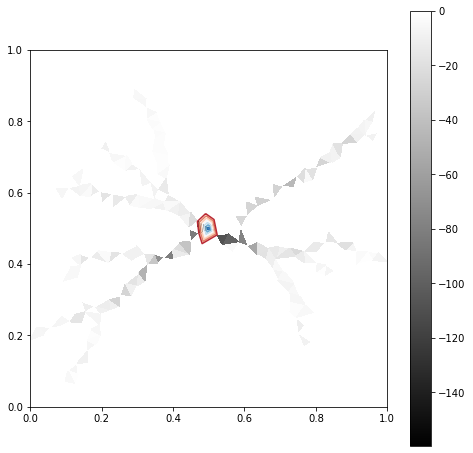

In [49]:
triang = mtri.Triangulation(coord.transpose()[0,:], coord.transpose()[1,:], topol)
fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.set_aspect('equal')
tpc = ax1.tripcolor(triang, -tdpot.tdens,  cmap='gray')
ax1.tricontour(triang, forcing, cmap='RdBu_r')
fig1.colorbar(tpc)
plt.show()

## Network pre-extraction:

Once the solution is obtained, it is time to convert it into a graph.

In [53]:
tdens_weights = tdpot.tdens
tdens_weights = tdens_weights/max(tdens_weights)
Gpe = pre_extraction.pre_extr(coord, 
                              topol, 
                              tdens_weights,
                              triang_source_indices,
                              triang_sink_indices, 
                              min_= 1e-5, 
                              graph_type='1')

The pre-extracted graph looks like this:

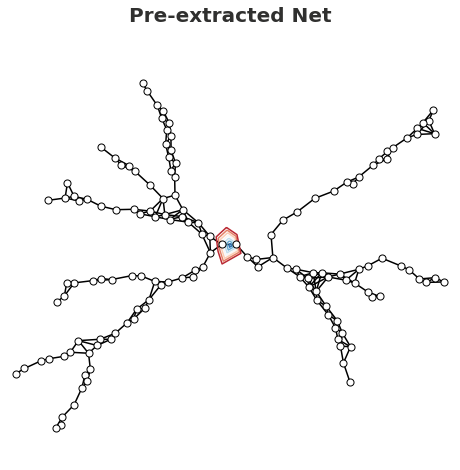

In [68]:
weights = np.array([Gpe.edges[edge]['tdens'] for edge in Gpe.edges()])
max_w = max(weights)
weights/=max_w

fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.tricontour(triang, forcing, cmap='RdBu_r')
pos_Gpe = nx.get_node_attributes(Gpe,'pos')
nx.draw(Gpe,pos_Gpe, 
        node_size = 50, 
        width = 1.5, 
        node_color='white',
         edgecolors='k',
        ax = ax1)
ax1.set_title(f'Pre-extracted Net', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
plt.show()

## Filtering:

As a last step, we would like to remove the redundancies of the pre-extracted network, all of those similarly located edges and nodes, by solving another OT problem. The source and sink information is then just learned from the continuous setting, and used to solve a new transportation problem. To get source/sink information, we run the following line:

In [55]:
sources,sinks = filtering.terminals_from_cont(Gpe, forcing_flag, extra_info, 
        btns_factor_source=1, btns_factor_sink=1, 
        terminal_criterion='btns')

Again, we choose the transportation scheme that we would like to use.

In [12]:
beta_d = 1.5

Now we are reading to solve the new transportation problem:

In [56]:
Gf,weights,colors, inputs_discr = filtering.filtering(
            Gpe, 
            sources, 
            sinks, 
            beta_d = beta_d, 
            tdens0 = 2, # 2 means not unitary (i.e., taken from Gpe)
            threshold = 1e-3, 
            weight_flag = 'length',
            stopping_threshold_f = 1e-2)

0.035073968601432345


The obtained simplified network looks like this:

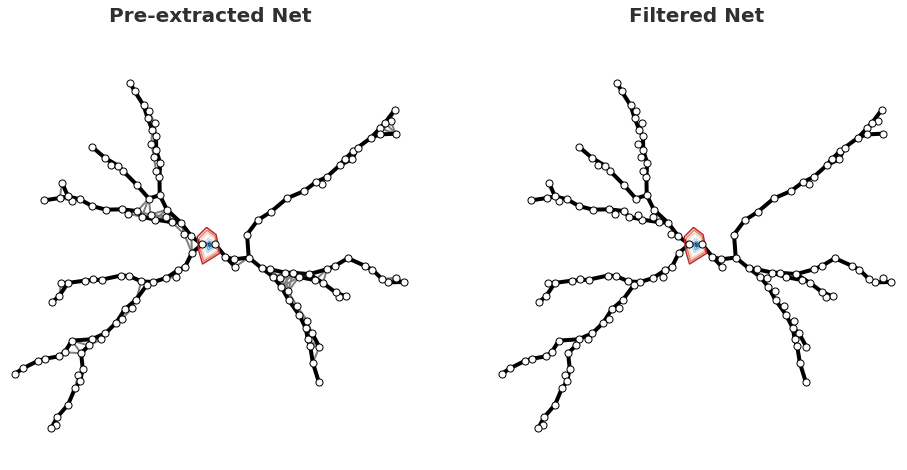

In [67]:
fig1, axs = plt.subplots(1,2,figsize=(16, 8))
ax1=axs[0]
ax1.tricontour(triang, forcing, cmap='RdBu_r')
pos_Gpe = nx.get_node_attributes(Gpe,'pos')
nx.draw(Gpe,pos_Gpe, 
        node_size = 50, 
        width = 2, 
        node_color='white',
         edgecolors='k',
        edge_color = 'gray',
            ax = ax1)
pos = nx.get_node_attributes(Gf,'pos')
nx.draw(Gf,pos, node_size =0, node_color = colors, width = 4 ,ax = ax1, with_labels = False)
ax1.set_title(f'Pre-extracted Net', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')

ax1=axs[1]
ax1.tricontour(triang, forcing, cmap='RdBu_r')
pos_Gpe = nx.get_node_attributes(Gpe,'pos')
nx.draw(Gpe,pos_Gpe, 
        node_size = 50, 
        width = 0, 
        node_color='white',
         edgecolors='k',
        edge_color = 'gray',
            ax = ax1)
pos = nx.get_node_attributes(Gf,'pos')
nx.draw(Gf,pos, node_size =0, node_color = colors, width = 4 ,ax = ax1, with_labels = False)
ax1.set_title(f'Filtered Net', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
plt.show()

Thanks for taking part of the tutorial!